# Pierre et le Loup : Introduction au Renforcement Apprentissage

Dans ce tutoriel, nous allons apprendre à appliquer l'apprentissage par renforcement à un problème de recherche de chemin. Le contexte est inspiré du conte musical [Pierre et le Loup](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) du compositeur russe [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). C'est l'histoire d'un jeune pionnier, Pierre, qui sort courageusement de sa maison pour aller dans la clairière de la forêt à la poursuite du loup. Nous allons entraîner des algorithmes d'apprentissage automatique qui aideront Pierre à explorer les environs et à construire une carte de navigation optimale.

Tout d'abord, importons quelques bibliothèques utiles :


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Aperçu de l'apprentissage par renforcement

**L'apprentissage par renforcement** (RL) est une technique d'apprentissage qui nous permet de découvrir un comportement optimal pour un **agent** dans un certain **environnement** en réalisant de nombreuses expériences. Un agent dans cet environnement doit avoir un **objectif**, défini par une **fonction de récompense**.

## L'environnement

Pour simplifier, considérons le monde de Peter comme un plateau carré de dimensions `width` x `height`. Chaque case de ce plateau peut être :
* **du sol**, sur lequel Peter et d'autres créatures peuvent marcher
* **de l'eau**, sur laquelle il est évidemment impossible de marcher
* **un arbre** ou **de l'herbe** - un endroit où l'on peut se reposer
* **une pomme**, qui représente quelque chose que Peter serait ravi de trouver pour se nourrir
* **un loup**, qui est dangereux et doit être évité

Pour interagir avec l'environnement, nous allons définir une classe appelée `Board`. Afin de ne pas surcharger ce notebook, nous avons déplacé tout le code lié au fonctionnement du plateau dans un module séparé appelé `rlboard`, que nous allons maintenant importer. Vous pouvez consulter ce module pour obtenir plus de détails sur les aspects internes de l'implémentation.


In [2]:
from rlboard import *

Créons maintenant un plateau aléatoire et voyons à quoi il ressemble :


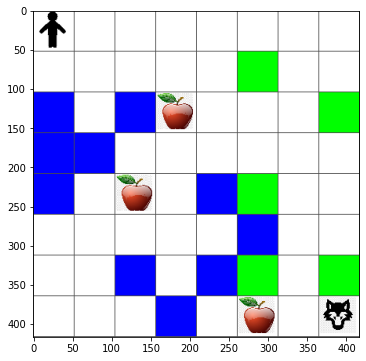

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Actions et Politique

Dans notre exemple, l'objectif de Peter serait de trouver une pomme, tout en évitant le loup et les autres obstacles. Pour ce faire, il peut essentiellement se déplacer jusqu'à ce qu'il trouve une pomme. Ainsi, à n'importe quelle position, il peut choisir entre l'une des actions suivantes : haut, bas, gauche et droite. Nous définirons ces actions sous forme de dictionnaire et les associerons à des paires de changements de coordonnées correspondants. Par exemple, se déplacer vers la droite (`R`) correspondrait à une paire `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

La stratégie de notre agent (Peter) est définie par ce qu'on appelle une **politique**. Considérons la politique la plus simple appelée **marche aléatoire**.

## Marche aléatoire

Commençons par résoudre notre problème en mettant en œuvre une stratégie de marche aléatoire.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Faisons l'expérience de marche aléatoire plusieurs fois et voyons le nombre moyen de pas effectués :


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Fonction de Récompense

Pour rendre notre politique plus intelligente, nous devons comprendre quels mouvements sont "meilleurs" que d'autres.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Construisez une Q-Table, ou un tableau multidimensionnel. Étant donné que notre plateau a des dimensions `width` x `height`, nous pouvons représenter la Q-Table par un tableau numpy de forme `width` x `height` x `len(actions)` :


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Passez la table Q à la fonction de tracé afin de visualiser la table sur le tableau :


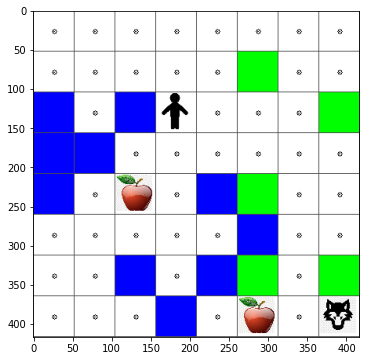

In [9]:
m.plot(Q)

## Essence de l'apprentissage Q : Équation de Bellman et algorithme d'apprentissage

Écrivez un pseudo-code pour notre algorithme d'apprentissage :

* Initialiser la table Q avec des valeurs égales pour tous les états et actions
* Définir le taux d'apprentissage $\alpha\leftarrow 1$
* Répéter la simulation plusieurs fois
   1. Commencer à une position aléatoire
   1. Répéter
        1. Sélectionner une action $a$ à l'état $s$
        2. Exécuter l'action en passant à un nouvel état $s'$
        3. Si nous rencontrons une condition de fin de jeu ou si la récompense totale est trop faible - quitter la simulation  
        4. Calculer la récompense $r$ dans le nouvel état
        5. Mettre à jour la fonction Q selon l'équation de Bellman : $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Mettre à jour la récompense totale et diminuer $\alpha$.

## Exploiter vs. Explorer

La meilleure approche consiste à trouver un équilibre entre exploration et exploitation. À mesure que nous apprenons davantage sur notre environnement, nous serons plus enclins à suivre la route optimale, tout en choisissant de temps en temps un chemin inexploré.

## Implémentation en Python

Nous sommes maintenant prêts à implémenter l'algorithme d'apprentissage. Avant cela, nous avons également besoin d'une fonction qui convertira des nombres arbitraires dans la table Q en un vecteur de probabilités pour les actions correspondantes :


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Nous ajoutons une petite quantité de `eps` au vecteur original afin d'éviter une division par zéro dans le cas initial, lorsque tous les composants du vecteur sont identiques.

L'algorithme d'apprentissage que nous allons exécuter pour 5000 expériences, également appelées **époques** :


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Après l'exécution de cet algorithme, la table Q devrait être mise à jour avec des valeurs qui définissent l'attractivité des différentes actions à chaque étape. Visualisez la table ici :


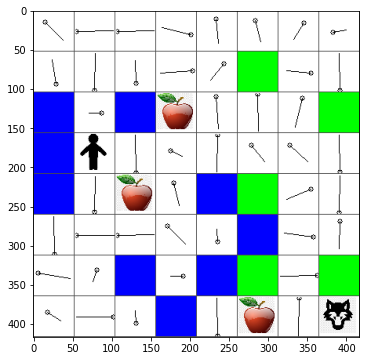

In [12]:
m.plot(Q)

## Vérification de la politique

Étant donné que la Q-Table répertorie "l'attractivité" de chaque action pour chaque état, il est assez simple de l'utiliser pour définir une navigation efficace dans notre monde. Dans le cas le plus simple, il suffit de sélectionner l'action correspondant à la valeur la plus élevée dans la Q-Table :


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Si vous essayez le code ci-dessus plusieurs fois, vous remarquerez peut-être qu'il "se bloque" parfois, et vous devez appuyer sur le bouton STOP dans le notebook pour l'interrompre.

> **Tâche 1 :** Modifiez la fonction `walk` pour limiter la longueur maximale du chemin à un certain nombre d'étapes (par exemple, 100), et observez le code ci-dessus renvoyer cette valeur de temps en temps.

> **Tâche 2 :** Modifiez la fonction `walk` afin qu'elle n'aille pas dans des endroits où elle est déjà passée auparavant. Cela empêchera `walk` de boucler, cependant, l'agent peut toujours se retrouver "coincé" dans un endroit dont il ne peut pas s'échapper.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


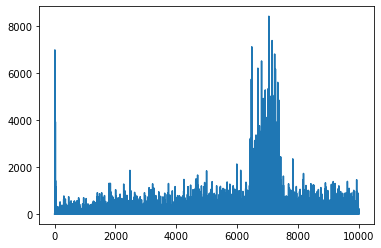

In [15]:
plt.plot(lpath)

Ce que nous observons ici, c'est qu'au début, la longueur moyenne des trajets a augmenté. Cela est probablement dû au fait que, lorsque nous ne savons rien de l'environnement, nous avons tendance à nous retrouver piégés dans des états défavorables, comme l'eau ou les loups. Au fur et à mesure que nous apprenons et commençons à utiliser ces connaissances, nous pouvons explorer l'environnement plus longtemps, mais nous ne savons toujours pas bien où se trouvent les pommes.

Une fois que nous avons suffisamment appris, il devient plus facile pour l'agent d'atteindre son objectif, et la longueur des trajets commence à diminuer. Cependant, nous restons ouverts à l'exploration, ce qui nous amène souvent à nous éloigner du meilleur chemin et à explorer de nouvelles options, rendant ainsi le trajet plus long que l'optimal.

Ce que nous observons également sur ce graphique, c'est qu'à un certain moment, la longueur a augmenté brusquement. Cela indique la nature stochastique du processus, et qu'il est possible, à un moment donné, de "détériorer" les coefficients de la Q-Table en les remplaçant par de nouvelles valeurs. Cela devrait idéalement être minimisé en réduisant le taux d'apprentissage (c'est-à-dire qu'à la fin de l'entraînement, nous ajustons les valeurs de la Q-Table uniquement par de petites quantités).

Dans l'ensemble, il est important de se rappeler que le succès et la qualité du processus d'apprentissage dépendent fortement des paramètres, tels que le taux d'apprentissage, la décroissance du taux d'apprentissage et le facteur d'actualisation. Ces paramètres sont souvent appelés **hyperparamètres**, pour les distinguer des **paramètres** que nous optimisons pendant l'entraînement (par exemple, les coefficients de la Q-Table). Le processus de recherche des meilleures valeurs d'hyperparamètres s'appelle **l'optimisation des hyperparamètres**, et il mérite un sujet à part entière.


## Exercice
#### Un monde plus réaliste pour Pierre et le Loup

Dans notre situation, Pierre pouvait se déplacer presque sans se fatiguer ni avoir faim. Dans un monde plus réaliste, il doit s'asseoir pour se reposer de temps en temps, et aussi se nourrir. Rendons notre monde plus réaliste en appliquant les règles suivantes :

1. En se déplaçant d'un endroit à un autre, Pierre perd **de l'énergie** et accumule de la **fatigue**.
2. Pierre peut regagner de l'énergie en mangeant des pommes.
3. Pierre peut se débarrasser de la fatigue en se reposant sous un arbre ou sur l'herbe (c'est-à-dire en marchant vers une case contenant un arbre ou de l'herbe - champ vert).
4. Pierre doit trouver et tuer le loup.
5. Pour tuer le loup, Pierre doit avoir certains niveaux d'énergie et de fatigue, sinon il perd le combat.

Modifiez la fonction de récompense ci-dessus en fonction des règles du jeu, exécutez l'algorithme d'apprentissage par renforcement pour apprendre la meilleure stratégie pour gagner le jeu, et comparez les résultats de la marche aléatoire avec votre algorithme en termes de nombre de parties gagnées et perdues.

> **Note** : Vous devrez peut-être ajuster les hyperparamètres pour que cela fonctionne, en particulier le nombre d'époques. Étant donné que le succès du jeu (affronter le loup) est un événement rare, vous pouvez vous attendre à un temps d'entraînement beaucoup plus long.



---

**Avertissement** :  
Ce document a été traduit à l'aide du service de traduction automatique [Co-op Translator](https://github.com/Azure/co-op-translator). Bien que nous nous efforcions d'assurer l'exactitude, veuillez noter que les traductions automatisées peuvent contenir des erreurs ou des inexactitudes. Le document original dans sa langue d'origine doit être considéré comme la source faisant autorité. Pour des informations critiques, il est recommandé de faire appel à une traduction humaine professionnelle. Nous déclinons toute responsabilité en cas de malentendus ou d'interprétations erronées résultant de l'utilisation de cette traduction.
